In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
def read_preprocessed(year):
    path = '../data/preprocessed/flights' + str(year) + '.csv'
    df = pd.read_csv(path, dtype={'airline': str,
                                  'di': 'Int8',
                                  'type': 'Int8',
                                  'origin_airport': str,
                                  'destination_ariport': str,
                                  'status': 'Int8',
                                  'reason': 'Int8',
                                  'origin_latitude': 'Float32',
                                  'origin_longitude': 'Float32',
                                  'destination_latitude': 'Float32',
                                  'destination_longitude': 'Float32',
                                  'domestic': bool},
                     parse_dates=['scheduled_departure', 'real_departure', 'scheduled_arrival', 'real_arrival'])
    return df

In [8]:
def construct_data(df):
    df = df[df['status'] == 1 | ~df['real_arrival'].isna()]

    # Fill in missing dates
    na_mask = df['scheduled_departure'].isna()
    df.loc[na_mask, 'scheduled_departure'] = df.loc[na_mask, 'real_departure']
    na_mask = df['scheduled_departure'].isna()
    df.loc[na_mask, 'scheduled_departure'] = df.loc[na_mask, 'real_arrival']

    df = df.rename(columns={'scheduled_departure': 'day'})

    # Group by day + domestic
    df = df.set_index('day').groupby([pd.Grouper(freq='D'), 'domestic'])['airline'].count()

    # Split groups in two columns
    df = df.reset_index().set_index('day')
    df = pd.DataFrame({ 'domestic': df.loc[df['domestic'], 'airline'], 'international': df.loc[~df['domestic'], 'airline'] })
    df = df.fillna(0)

    # Calculate moving averages
    def moving_average(x, N=7):
        cumsum = np.cumsum(np.array([np.mean(x[:N])] * N + list(x))) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

    df['domestic_avg'] = moving_average(df['domestic'], 14)
    df['international_avg'] = moving_average(df['international'], 14)

    return df

In [9]:
final_df = pd.DataFrame()
for y in range(2000, 2021):
    df = read_preprocessed(y)
    df = construct_data(df)
    final_df = pd.concat([final_df, df])

In [10]:
final_df.to_csv('../data/count_by_day.csv')
print(final_df.shape)
final_df.head()

(7549, 4)


,domestic,international,domestic_avg,international_avg
day,,,,
2000-01-01,1384,41,2190.729592,46.239796
2000-01-02,1966,52,2170.244898,46.622449
2000-01-03,2370,44,2178.617347,46.433673
2000-01-04,2359,49,2186.204082,46.602041
2000-01-05,2417,49,2197.933673,46.770408


<AxesSubplot:xlabel='day'>

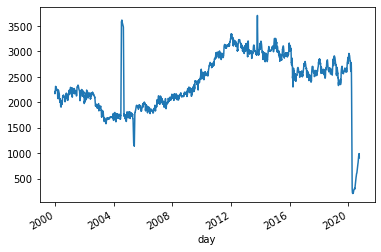

In [11]:
final_df['domestic_avg'].plot(kind='line')

<AxesSubplot:xlabel='day'>

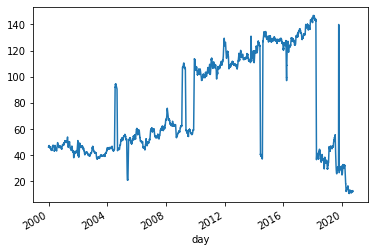

In [12]:
final_df['international_avg'].plot(kind='line')